# SDP-LMC Queue Connector - RCAL Pointings Demo

This notebook contains demonstration configurations of a LMC Queue Connector between DISH pointings Tango attributes to SDP.

The data pipeline and format for pointing offsets is yet to be decided, however if the queue connector does not need to interpret the messages for gathering/scattering, it's possible to simply connect raw variable length byte data streams together, both of which Kafka and Tango understand. For example, the numpy structured array API provides simple utils to convert to and from byte format for an array of the following structure:

```
class Pointing:
    dish: int64
    timestamp: datetime64[ns]
    az: double
    el: double
```

Legend: d: Dish ID, s: Subarray ID

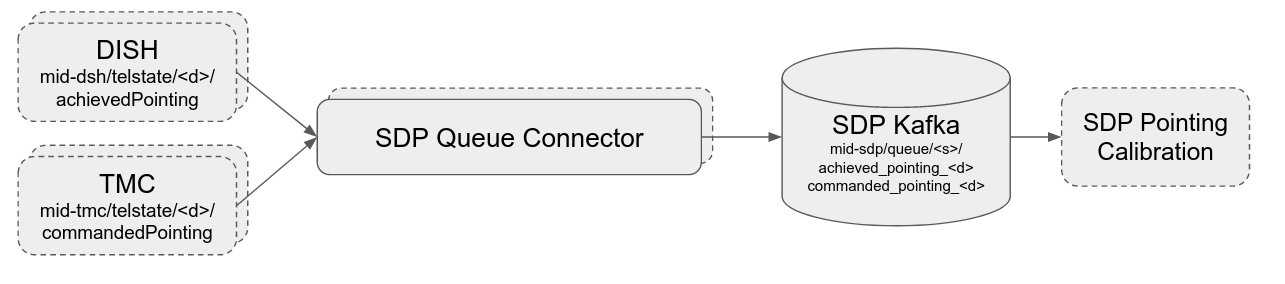


In [1]:
import os

KUBE_NAMESPACE = "<insert namespace here>"

# set the host names of the database and tango services
DATABASEDS_NAME = "databaseds-tango-base"
KAFKA_HOST = f"ska-sdp-qa-kafka.{KUBE_NAMESPACE}.svc.cluster.local"
os.environ["SDP_CONFIG_HOST"] = f"ska-sdp-etcd-client.{KUBE_NAMESPACE}"
os.environ["TANGO_HOST"] = f"{DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.cluster.local:10000"


In [2]:
import tango
import ska_sdp_config

config_db = ska_sdp_config.Config()

# Similar to the Standby command, updating the database with this
# config will turn off and leave the queue connector in Standby.
EMPTY_CONFIG = '{}'

# Tango and Database Paths
pointings_qc = tango.DeviceProxy('test-sdp/queueconnector/01')
POINTINGS_QC_CONFIG_PATH = "/eb/eb_id/queueconnector/pointings"
if config_db.backend.get(POINTINGS_QC_CONFIG_PATH)[0] is None:
    config_db.backend.create(POINTINGS_QC_CONFIG_PATH, EMPTY_CONFIG)

# extra device for mocking
mock_qc = tango.DeviceProxy('test-sdp/queueconnector/02')
MOCK_QC_CONFIG_PATH = "/eb/eb_id/queueconnector/mock"
if config_db.backend.get(MOCK_QC_CONFIG_PATH)[0] is None:
    config_db.backend.create(MOCK_QC_CONFIG_PATH, EMPTY_CONFIG)


In [3]:
# Notebook Utilities

def go_to_standby_state(device):
    if device.State() == tango.DevState.FAULT:
        device.Reset()
    if device.State() == tango.DevState.ON:
        device.Stop()
    if device.State() == tango.DevState.OPEN:
        device.Abort()
    if device.State() == tango.DevState.CLOSE:
        device.Abort()
    if device.State() == tango.DevState.OFF:
        device.Standby()
    assert device.State() == tango.DevState.STANDBY


# Setup Pointing Config

Note: By using the "bytes" format the queue connector and config does not need to know the pointings structure (only whether it is encoded as npy or carray)  

In [4]:
import json
import time
from typing import Iterable

def create_config(dish_ids: Iterable[int]):
    return { "exchanges": [
        {
            "dtype": "bytes",
            "shape": [],
            "source": {
                "type": "TangoSubscriptionSource",
                "device_name": "test-sdp/queueconnector/02",
                "attribute_name": f"{d}/achievedPointing",
            },
            "sink": {
                "type": "KafkaProducerSink",
                "topic": f"achieved_pointing",
                "servers": KAFKA_HOST,
                "encoding": "carray"
            }
        }
        for d in dish_ids
    ]}


In [5]:
try:
    import aiokafka
except ModuleNotFoundError:
    !pip install aiokafka
    import aiokafka
import math
import datetime
import numpy as np

POINTING_DTYPE = [
    ("dish", int),
    ("timestamp", "datetime64[ns]"),
    ("az", np.double),
    ("el", np.double),
]

def create_mock_config(dish_ids: Iterable[int]):
    return {"exchanges": [
            {
                # Mock data into Tango array attribute via kafka
                # (cannot write bytestring to json)
                "dtype": "bytes",
                "shape": [],
                "source": {
                    "type": "KafkaConsumerSource",
                    "topic": f"achieved_pointing_{d}",
                    "servers": KAFKA_HOST,
                    "encoding": "carray"
                },
                "sink": {
                    "type": "TangoLocalAttributeSink",
                    "attribute_name": f"{d}/achievedPointing",
                    "default_value": ""
                }
            }
            for d in dish_ids
        ]}


async def mock_pointings(dish_ids: Iterable[int], num_mock_iterations: int):
    async with aiokafka.AIOKafkaProducer(
        bootstrap_servers=KAFKA_HOST
    ) as producer:
        for iteration in range(num_mock_iterations):
            for dish_id in dish_ids:
                pointing = np.array([(
                        dish_id,
                        datetime.datetime.now(),
                        math.sin(iteration),
                        math.cos(iteration)
                    )],
                    dtype=POINTING_DTYPE
                )
                await producer.send(
                    f"achieved_pointing_{dish_id}",
                    pointing.tobytes()
                )


# Setup device to Monitor Configuration Database

The queue connector is capable of monitoring the configuration database to automatically drive it's configuration and state machine. This mode can be checked using the `IsMonitoringDB` command.

In [6]:
import asyncio

config_db.backend.update(POINTINGS_QC_CONFIG_PATH, EMPTY_CONFIG)
config_db.backend.update(MOCK_QC_CONFIG_PATH, EMPTY_CONFIG)

await asyncio.sleep(0.1)

go_to_standby_state(pointings_qc)
pointings_qc.Configure(POINTINGS_QC_CONFIG_PATH)
print(f"pointings qc - isMonitoringDB: {pointings_qc.IsMonitoringDB()}, State: {pointings_qc.State()}")

go_to_standby_state(mock_qc)
mock_qc.Configure(MOCK_QC_CONFIG_PATH)
print(f"mock qc - isMonitoringDB: {mock_qc.IsMonitoringDB()}, State: {mock_qc.State()}")


mock qc - isMonitoringDB: True, State: STANDBY
pointings qc - isMonitoringDB: True, State: STANDBY


# Run Pipeline and Profile

In [7]:
import logging
import ska_ser_logging
import asyncio
from tango import EventType, DevState
from contextlib import suppress

from utils.tango_utils import SubscribeEventConditionContext

logger = logging.getLogger(__name__)
ska_ser_logging.configure_logging(level=logging.INFO)
loop = asyncio.get_running_loop()
received_queue = asyncio.Queue()

# Constant Variables
NUM_RECEPTORS = 197
NUM_MOCK_ITERATIONS = 10
dish_ids = range(NUM_RECEPTORS)

async def async_pointing_handler():
    async with aiokafka.AIOKafkaConsumer(
        "achieved_pointing",
        bootstrap_servers=KAFKA_HOST
    ) as consumer:
        async for pointing_data in consumer:
            pointing = np.frombuffer(pointing_data.value, dtype=POINTING_DTYPE)
            logging.debug(
                "consumer received: %s %s",
                f"{len(pointing_data.value)} bytes",
                pointing
            )
            await received_queue.put(pointing)

print("Configuring..")
# setup mock device
with SubscribeEventConditionContext(mock_qc, "State", EventType.CHANGE_EVENT) as device_state:
    config_db.backend.update(MOCK_QC_CONFIG_PATH, json.dumps(create_mock_config(dish_ids)))
    await device_state.wait_for(DevState.ON, timeout=5)

# setup sdp connections
with SubscribeEventConditionContext(pointings_qc, "State", EventType.CHANGE_EVENT) as device_state:
    config_db.backend.update(POINTINGS_QC_CONFIG_PATH, json.dumps(create_config(dish_ids)))
    await device_state.wait_for(DevState.ON, timeout=5)

# hook up to notebook
async_handler = asyncio.create_task(async_pointing_handler())
try:
    # start mock data
    print("Mocking..")
    start_time = time.perf_counter()
    await mock_pointings(range(NUM_RECEPTORS), NUM_MOCK_ITERATIONS)
    print("Mocking complete")
    
    # wait for expected number of topic entries
    while received_queue.qsize() < NUM_MOCK_ITERATIONS * NUM_RECEPTORS:
        await asyncio.sleep(0.1)

    end_time = time.perf_counter()

    print(f"received {received_queue.qsize()} pointings")
    total_time = end_time - start_time
    print(f"total time: {end_time - start_time}")
    print(f"rate: {NUM_MOCK_ITERATIONS / total_time}Hz")
finally:
    # remove notebook handler
    async_handler.cancel()
    with suppress(asyncio.CancelledError):
        await async_handler
    
# stop mock and sdp connections
config_db.backend.update(POINTINGS_QC_CONFIG_PATH, EMPTY_CONFIG)
config_db.backend.update(MOCK_QC_CONFIG_PATH, EMPTY_CONFIG)

print("Done")

Configuring..
Mocking..
1|2023-05-16T04:50:39.161Z|INFO|MainThread|_change_subscription|subscription_state.py#111||Updating subscribed topics to: frozenset({'achieved_pointing'})
1|2023-05-16T04:50:39.247Z|INFO|MainThread|_handle_metadata_update|group_coordinator.py#57||Metadata for topic has changed from {} to {'achieved_pointing': 1}. 
Mocking complete
received 1970 pointings
total time: 1.5173329761018977
rate: 6.590511217709436Hz
Done
